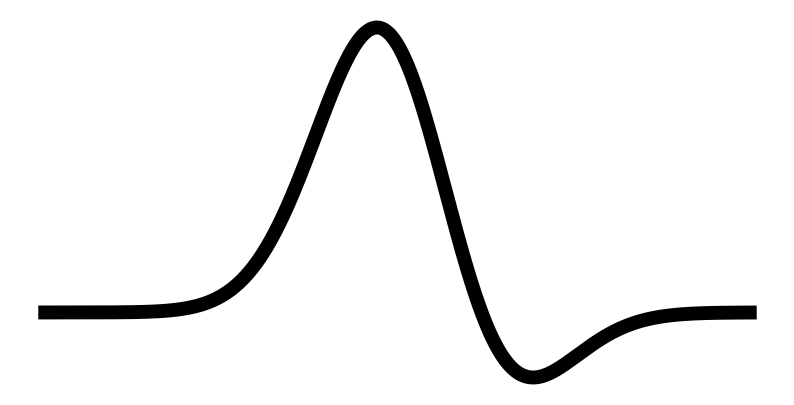

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Time array in milliseconds
time = np.linspace(0, 5, 1000)

# Parameters for the pulse
pulse_center = 2.5  # Center of the pulse in milliseconds
pulse_width = 0.5   # Width of the pulse (standard deviation)
pulse_height = 1.0  # Peak value of the pulse
pulse_depth = -0.5  # Minimum value of the pulse

# Function to create an up and down pulse
def up_down_pulse(t, center, width, height, depth):
    pulse_up = height * np.exp(-0.5 * ((t - center) / width) ** 2)
    pulse_down = depth * np.exp(-0.5 * ((t - (center + width)) / width) ** 2)
    return pulse_up + pulse_down

# Generate pulse values
pulse = up_down_pulse(time, pulse_center, pulse_width, pulse_height, pulse_depth)

# Plotting without labels, ticks, or grid
plt.figure(figsize=(10, 5))
plt.plot(time, pulse, color='black', linewidth=10)
plt.xticks([])  # Remove x-ticks
plt.yticks([])  # Remove y-ticks
plt.box(False)  # Remove the box around the plot

plt.savefig(r'C:\Users\marco\UIC\4\2sem\TFG\work_report\defense\img\pulse.png', transparent=True, bbox_inches='tight')


In [1]:
import os
import sys
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

# Import custom code
from network import RipplesNetwork
from train_aux import torchSlayer_Dataset

# Import subprocess for external commands
import subprocess as sh

In [3]:
# Set general variables
epochs = 50
y_sizes = [50]
folder = 'one_output'
for y_size in y_sizes:
    trained_folder = f'{folder}/256_128/E{epochs}_Y{y_size}/'
    os.makedirs(trained_folder, exist_ok=True)

    # Assign the runtime method
    device = torch.device('cpu')

    # Test-Train data preparation
    print('Loading data ...', end='')
    true_positives = np.load(f'../dataset/{y_size}/n_true_positives.npy')
    true_negatives = np.load(f'../dataset/{y_size}/n_true_negatives.npy')

    # Create labels for the datasets (1 for true positives, 0 for true negatives)
    labels_positives = np.ones(len(true_positives)).astype(int)
    labels_negatives = np.zeros(len(true_negatives)).astype(int)

    # Concatenate the datasets and labels
    data = np.concatenate((true_positives, true_negatives), axis=0)
    labels = np.concatenate((labels_positives, labels_negatives))

    # Split the dataset into training and testing sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)

    train = torchSlayer_Dataset(train_data, train_labels)
    test = torchSlayer_Dataset(test_data, test_labels)

    train_loader = DataLoader(dataset=train, batch_size=32, shuffle=True)
    test_loader  = DataLoader(dataset=test , batch_size=32, shuffle=True)
    print('Done!')

    # Define the structure of the model
    # Create network object and training objects
    net = RipplesNetwork(y_input_size=y_size, str_layers="256_128").to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device) 
    # error = slayer.loss.SpikeTime(time_constant=5, length=100, filter_order=1, reduction='sum').to(device)
    stats = slayer.utils.LearningStats()
    assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)
    # assistant = slayer.utils.Assistant(net, error, optimizer, stats) # Regression mode

    # Train the model

    print('Starting training!')
    samples = 0
    for epoch in range(epochs):
        samples = 0
        for i, (input, label) in enumerate(train_loader): # training loop
            samples += input.shape[0]
            print(samples, end='\r', flush=True)
            output = assistant.train(input, label)
        print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
            
        for i, (input, label) in enumerate(test_loader): # training loop
            output = assistant.test(input, label)
        print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
            
        if epoch%20 == 19: # cleanup display
            print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
            stats_str = str(stats).replace("| ", "\n")
            print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
        
        if stats.testing.best_accuracy:
            torch.save(net, trained_folder + '/network.pt')
        stats.update()
        stats.save(trained_folder + '/')
        # stats.plot(figsize=(15, 5), path=trained_folder)
        # net.grad_flow(trained_folder + '/')

        # sh.run(['python3.9', 'plot_accuracies.py', folder])
        # sh.run(['bash', 'update_git.sh'])
    


Loading data ...Done!
Starting training!
                                                                                                                                                                                           
[Epoch 19/50]
Train loss =     0.10555 (min =     0.10024)     accuracy = 0.94495 (max = 0.94808)  
Test  loss =     0.10618 (min =     0.10158)     accuracy = 0.93593 (max = 0.94290) 
                                                                                                                                                                                           
[Epoch 39/50]
Train loss =     0.10351 (min =     0.10003)     accuracy = 0.95052 (max = 0.95122)  
Test  loss =     0.10887 (min =     0.10037)     accuracy = 0.93872 (max = 0.94429) 
[Epoch 49/50] Train loss =     0.10085 (min =     0.09814)     accuracy = 0.95087 (max = 0.95157)  | Test  loss =     0.11504 (min =     0.09861)     accuracy = 0.94011 (max = 0.94429) 32

In [5]:
# Train the model

print('Starting training!')
samples = 0
for epoch in range(epochs):
    samples = 0
    for i, (input, label) in enumerate(train_loader): # training loop
        samples += input.shape[0]
        print(samples, end='\r', flush=True)
        output = assistant.train(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    for i, (input, label) in enumerate(test_loader): # training loop
        output = assistant.test(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    if epoch%20 == 19: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        stats_str = str(stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
    
    if stats.testing.best_accuracy:
        net.export_hdf5(trained_folder + '/network.net')
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    # stats.plot(figsize=(15, 5), path=trained_folder)
    # net.grad_flow(trained_folder + '/')

Starting training!


KeyboardInterrupt: 

## Test the model

In [5]:
from torch import tensor

In [6]:
for input, label in train_loader:
    break

In [61]:
trial_input = np.load('../report_util/extract_Nripples/input_trial_no_ripple.npy')

trial_input2network = torch.zeros((1, trial_input.shape[0], trial_input.shape[1]))

trial_input2network[0, :, :] = tensor(trial_input[:, i*trial_input.shape[1]:(i+1)*trial_input.shape[1]])

print(trial_input2network.shape)

torch.Size([1, 50, 600])


In [62]:
output = net(trial_input2network.to(device))
output.shape

torch.Size([1, 2, 600])

In [63]:
predictions = np.zeros((output.shape[1], output.shape[0] * output.shape[2]))
for i, batch in enumerate(output):
    predictions[:, batch.shape[1]*i:batch.shape[1]*(i+1)] = batch.detach().numpy()

predictions.shape

(2, 600)

In [10]:
sys.path.insert(0, '../report_util/extract_Nripples/')
from anim import slayer_gif

slayer_gif(predictions, filename='../report_util/gifs/output', figsize=(30, 5), fps=5)

In [12]:
import IPython.display as display

gif_td = lambda gif: f'<tr><td> <img src="{gif}" alt="Drawing" style="height: 250px;"/> </td></tr>'
html = '<table>'
html += '<tr><td align="center"><b>Input</b></td></tr>'
html += gif_td(f'gifs/ripple.gif')
html += '<tr><td align="center"><b>Output</b></td></tr>'
html += gif_td(f'gifs/output.gif')
html += '</table>'
display.HTML(html)

Input
""
Output
""
